In [9]:
import drawsvg as dw
from os import listdir
dir = '/home/jh/src/svg/lib'
files = listdir(dir)
for file in files:
    if file[-3:] == '.py':
        f = '%s/%s' % (dir,file)
        exec(open(f).read())

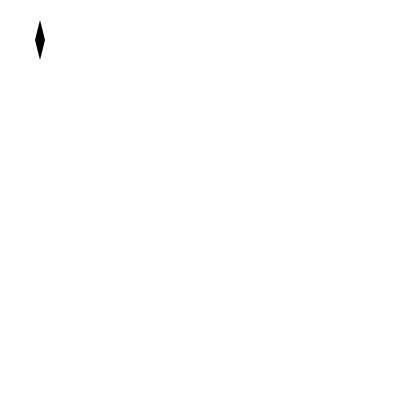

In [8]:
d = dw.Drawing(200,200)

def raute(x=20,y=20,w=5,h=20,c='black',f='black',sw=0,**args):
    """xy ist der mittelpunkt
    w und h die absolute breite und höhe
    wenn hohl, f='none' setzen"""
    p1 = x-w/2,y
    p2 = x,y-h/2
    p3 = x+w/2,y
    p4 = x,y+h/2
    p = dw.Path(stroke=c,stroke_width=sw,fill=f,**args)
    p.M(*p1).L(*p2).L(*p3).L(*p4).L(*p1)
    d.append(p)

raute()

d.set_pixel_scale(2)
#d.save_png('varVib.png')
#d.save_svg('varVib.svg')
d